# Strojenie hiperparametrów

## Zadanie 1

### Pobranie danych

In [38]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, 
                                                              housing.target,
                                                              random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)


In [39]:
scaler = StandardScaler() # skalowanie aby wartosci mialy podobna skale
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)



## Zadanie 2


### Przeszukiwanie przestrzeni hiperparametrów przy pomocy scikit-learn


Celem ćwiczenia jest przejrzenie przestrzeni parametrów w następujących zakresach:
1. krok uczenia: [3 ⋅ 10−4, 3 ⋅ 10−2],
2. liczba warstw ukrytych: od 0 do 3,
3. liczba neuronów na warstwę: od 1 do 100,
4. algorytm optymalizacji: adam, sgd lub nesterov.

In [40]:
import numpy as np
from scipy.stats import reciprocal

param_distribs = {
    "model__n_hidden" : [0,1,2,3],
    "model__n_neurons" : np.arange(1, 101),
    "model__learning_rate" : reciprocal(3e-4, 3e-2),   # losowa wartosc z tego zakresu - rozklad odwrotnu
    "model__optimizer" : ["adam", "sgd", "nesterov"]
}



In [41]:

def build_model(n_hidden, n_neurons, optimizer, learning_rate):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]))
    for layer in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(1))
    optimizer_instance = None
    optimizer_str_lower = optimizer.lower() 
    if optimizer_str_lower == 'adam':
        optimizer_instance = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_str_lower == 'sgd':
        optimizer_instance = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer_str_lower == 'momentum':
        optimizer_instance = tf.keras.optimizers.SGD(
            learning_rate=learning_rate, 
            momentum=0.9
        )
    elif optimizer_str_lower == 'nesterov':
        optimizer_instance = tf.keras.optimizers.SGD(
            learning_rate=learning_rate, 
            nesterov=True,
            momentum=0.9)
    model.compile(loss="mse", optimizer=optimizer_instance)
    return model


In [42]:
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV



learning_rates = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

h = []

for learning_rate in learning_rates:
    model = build_model(n_hidden=2, n_neurons=15, optimizer="adam", learning_rate=learning_rate)
    history = model.fit(X_train, y_train, epochs=40,
                        validation_data=(X_valid, y_valid)) # walidacyjny jest by ocenic postepy w trakcie uczenia
    h.append(history)


Epoch 1/40


c:\Users\chame\miniforge3\envs\ml\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.2163 - val_loss: 12.9503
Epoch 2/40
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.9390 - val_loss: 12.9000
Epoch 3/40
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.1587 - val_loss: 12.8516
Epoch 4/40
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.0537 - val_loss: 12.8031
Epoch 5/40
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.0613 - val_loss: 12.7539
Epoch 6/40
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.2580 - val_loss: 12.7063
Epoch 7/40
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.9632 - val_loss: 12.6569
Epoch 8/40
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.0245 - val_loss: 12.6100
Epoch 9/40
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.9657 - val_loss: 12.5616
Epoch 10/40
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.1114 - val_loss: 12.5157
Epoch 11/40
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.9679 - val_loss: 12.4692
Epoch 12/40
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

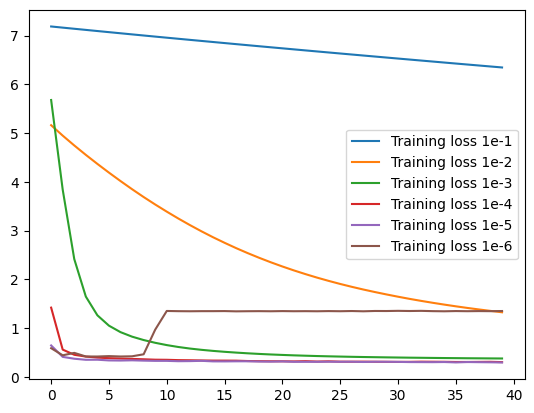

In [43]:
import matplotlib.pyplot as plt

for i, h_i in enumerate(h):
    plt.plot(h_i.history['loss'], label=f"Training loss 1e-{i+1}")
plt.legend()

In [44]:
import scikeras
from scikeras.wrappers import KerasRegressor

es = tf.keras.callbacks.EarlyStopping(patience=10, min_delta=1.0, verbose=1)  # verbose 1 to ze beda komunikaty ze sie zatrzymal

keras_reg_model = KerasRegressor(build_model, callbacks=[es])

In [45]:
from sklearn.model_selection import RandomizedSearchCV

rnd_search_cv = RandomizedSearchCV(estimator=keras_reg_model, # model do dostrojeniaerror_score=
                                   param_distributions=param_distribs, # slownik hiperparametrow
                                   n_iter=5, # liczba kombinacji hiperparametrow ktore zostana sprawdzone
                                   cv=3, 
# ccv = 3 - cross-validation na 3 czesci, tzn raz trenowany na 1 i 2 czesci a testowany na 3, potem 1 i 3 i test na 2 i potem 2 i 3 i test na 1
                                   verbose=2) # bardziej szczegolowe logi

In [46]:
rnd_search_cv.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), verbose=0)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


c:\Users\chame\miniforge3\envs\ml\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 11: early stopping
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
[CV] END model__learning_rate=0.02005553864055598, model__n_hidden=2, model__n_neurons=98, model__optimizer=nesterov; total time=   8.7s


c:\Users\chame\miniforge3\envs\ml\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\chame\miniforge3\envs\ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\chame\miniforge3\envs\ml\Lib\site-packages\sklearn\metrics\_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\chame\miniforge3\envs\ml\Lib\site-packages\scikeras\wrappers.py", line 1127, in score
    return self.scorer(y, y_pred, sample_weight=sample_weight, **score_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\chame\miniforge3\envs\ml\Lib\s

Epoch 11: early stopping
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
[CV] END model__learning_rate=0.02005553864055598, model__n_hidden=2, model__n_neurons=98, model__optimizer=nesterov; total time=   7.0s


c:\Users\chame\miniforge3\envs\ml\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 11: early stopping
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[CV] END model__learning_rate=0.02005553864055598, model__n_hidden=2, model__n_neurons=98, model__optimizer=nesterov; total time=   7.2s


c:\Users\chame\miniforge3\envs\ml\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\chame\miniforge3\envs\ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\chame\miniforge3\envs\ml\Lib\site-packages\sklearn\metrics\_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\chame\miniforge3\envs\ml\Lib\site-packages\scikeras\wrappers.py", line 1127, in score
    return self.scorer(y, y_pred, sample_weight=sample_weight, **score_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\chame\miniforge3\envs\ml\Lib\s

Epoch 21: early stopping
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
[CV] END model__learning_rate=0.014133341603417568, model__n_hidden=0, model__n_neurons=10, model__optimizer=nesterov; total time=  12.0s


c:\Users\chame\miniforge3\envs\ml\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 26: early stopping
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step
[CV] END model__learning_rate=0.014133341603417568, model__n_hidden=0, model__n_neurons=10, model__optimizer=nesterov; total time=  12.0s


c:\Users\chame\miniforge3\envs\ml\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 12: early stopping
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
[CV] END model__learning_rate=0.014133341603417568, model__n_hidden=0, model__n_neurons=10, model__optimizer=nesterov; total time=   5.7s


c:\Users\chame\miniforge3\envs\ml\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 11: early stopping
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[CV] END model__learning_rate=0.001540071440811249, model__n_hidden=2, model__n_neurons=91, model__optimizer=adam; total time=   6.6s


c:\Users\chame\miniforge3\envs\ml\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 11: early stopping
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
[CV] END model__learning_rate=0.001540071440811249, model__n_hidden=2, model__n_neurons=91, model__optimizer=adam; total time=   6.4s


c:\Users\chame\miniforge3\envs\ml\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 11: early stopping
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
[CV] END model__learning_rate=0.001540071440811249, model__n_hidden=2, model__n_neurons=91, model__optimizer=adam; total time=   6.5s


c:\Users\chame\miniforge3\envs\ml\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 18: early stopping
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step
[CV] END model__learning_rate=0.0005147113767992434, model__n_hidden=0, model__n_neurons=61, model__optimizer=sgd; total time=   7.9s


c:\Users\chame\miniforge3\envs\ml\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 24: early stopping
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[CV] END model__learning_rate=0.0005147113767992434, model__n_hidden=0, model__n_neurons=61, model__optimizer=sgd; total time=  11.3s


c:\Users\chame\miniforge3\envs\ml\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 18: early stopping
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
[CV] END model__learning_rate=0.0005147113767992434, model__n_hidden=0, model__n_neurons=61, model__optimizer=sgd; total time=  10.8s


c:\Users\chame\miniforge3\envs\ml\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 12: early stopping
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step
[CV] END model__learning_rate=0.0032924402241247806, model__n_hidden=2, model__n_neurons=39, model__optimizer=sgd; total time=   5.4s


c:\Users\chame\miniforge3\envs\ml\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 13: early stopping
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
[CV] END model__learning_rate=0.0032924402241247806, model__n_hidden=2, model__n_neurons=39, model__optimizer=sgd; total time=   5.8s


c:\Users\chame\miniforge3\envs\ml\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 13: early stopping
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step
[CV] END model__learning_rate=0.0032924402241247806, model__n_hidden=2, model__n_neurons=39, model__optimizer=sgd; total time=   5.8s


c:\Users\chame\miniforge3\envs\ml\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [            nan -3.90775168e+03  7.55431127e-01  5.05096263e-01
  7.13662900e-01]
  warnings.warn(
c:\Users\chame\miniforge3\envs\ml\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 13: early stopping


RandomizedSearchCV(cv=3,
                   estimator=KerasRegressor(callbacks=[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x0000026A45D9BFD0>], model=<function build_model at 0x0000026A4D937380>),
                   n_iter=5,
                   param_distributions={'model__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000026A3526B110>,
                                        'model__n_hidden': [0, 1, 2, 3],
                                        'model__n_neurons': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100]),
                                        'model__optimizer': ['adam', 'sgd',
                                                             'nesterov']},
                   verbose=2)

In [47]:
import pickle

print(f"Best estimator: {rnd_search_cv.best_estimator_}")

print(f"Best score: {rnd_search_cv.best_score_}") # najlepszy sredni wynik (score)

best_params_dict = rnd_search_cv.best_params_

print(best_params_dict)


with open('rnd_search_params.pkl', 'wb') as file:
    pickle.dump(best_params_dict, file)

Best estimator: KerasRegressor(
	model=<function build_model at 0x0000026A4D937380>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x0000026A18526910>]
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	model__learning_rate=0.001540071440811249
	model__n_hidden=2
	model__n_neurons=91
	model__optimizer=adam
)
Best score: 0.7554311269575242
{'model__learning_rate': 0.001540071440811249, 'model__n_hidden': 2, 'model__n_neurons': 91, 'model__optimizer': 'adam'}


In [48]:
with open('rnd_search_scikeras.pkl', 'wb') as file:
    pickle.dump(rnd_search_cv, file)

## Zadanie 2.3 Przeszukiwanie przestrzeni hiperparametrów przy pomocy Keras Tuner

In [49]:
import keras_tuner as kt

1. krok uczenia: [3 ⋅ 10−4, 3 ⋅ 10−2],
2. liczba warstw ukrytych: od 0 do 3,
3. liczba neuronów na warstwę: od 1 do 100,
4. algorytm optymalizacji: adam, sgd lub nesterov.


In [50]:
def build_model_kt(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=3, default=2)
    n_neurons = hp.Int("n_neurons", min_value=1, max_value=100)
    learning_rate = hp.Float("learning_rate", min_value=3e-4, max_value=3e-2, sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam", "nesterov"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == "nesterov":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, nesterov=True)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(1, activation=None)) # no bo to regresja

    model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["mse", 'mae'])
    return model

    


In [51]:
random_search_tuner = kt.RandomSearch(
    build_model_kt, objective="val_mse", max_trials=10,
    overwrite=True, directory="my_california_housing",
    project_name="my_rnd_search", seed=42
)

In [52]:
import os

root_logdir = os.path.join(random_search_tuner.project_dir, 'tensorboard')
tb = tf.keras.callbacks.TensorBoard(root_logdir)

In [53]:
random_search_tuner.search(X_train, y_train, epochs=100,
                           validation_data=(X_valid, y_valid),
                           callbacks=[es, tb])

Trial 10 Complete [00h 00m 14s]
val_mse: 0.353168785572052

Best val_mse So Far: 0.2909252643585205
Total elapsed time: 00h 02m 42s


In [54]:
best_hyperparameters = random_search_tuner.get_best_hyperparameters(num_trials=1)
best_hps = best_hyperparameters[0]

n_hidden = best_hps.get('n_hidden')
n_neurons = best_hps.get('n_neurons')
learning_rate = best_hps.get('learning_rate')
optimizer = best_hps.get('optimizer')


print(f'Best n_hidden = {n_hidden}')
print(f'Best n_nuerons = {n_neurons}')
print(f'Best learing_rate = {learning_rate}')
print(f'Best optimizer = {optimizer}')

best_params_tuner_dict = {
    'n_hidden' : n_hidden,
    'n_neurons' : n_neurons,
    'learning_rate' : learning_rate,
    'optimizer' : optimizer
}

print(best_params_tuner_dict)



Best n_hidden = 3
Best n_nuerons = 45
Best learing_rate = 0.002688052701561945
Best optimizer = adam
{'n_hidden': 3, 'n_neurons': 45, 'learning_rate': 0.002688052701561945, 'optimizer': 'adam'}


In [56]:
with open('kt_search_params.pkl', 'wb') as file:
    pickle.dump(best_params_tuner_dict, file)

best_model_list = random_search_tuner.get_best_models(num_models=1)
b_model = best_model_list[0]

# with open('kt_best_model.keras', 'wb') as file:
#     pickle.dump(best_model, file)

b_model.save('kt_best_model.keras')